In [1]:
import numpy as np
import GPy
import seaborn as sns
import math
import matplotlib.pyplot as plt
import edward as ed
import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tfe.enable_eager_execution()
from edward.models import MultivariateNormalFullCovariance, Normal
from scipy.stats import bernoulli
from tensorflow.contrib.distributions import  Bernoulli
from tensorflow.contrib.distributions import Categorical

In [2]:
class RBF():
    
    def __init__(self, input_dim, variance=1., lengthscale=1.):
        self.input_dim = input_dim
        self.variance = variance
        self.lengthscale = lengthscale
        
    def K(self, X, X2):
        return self.variance * tf.exp(-self.square_dist(X, X2) / 2)
        
    def square_dist(self, X, X2):
        X = X / self.lengthscale
        Xs = tf.reduce_sum(tf.square(X), 1)
        if X2 is None:
            return -2 * tf.matmul(X, tf.transpose(X)) + tf.reshape(Xs, (-1, 1)) + tf.reshape(Xs, (1, -1))
        else:
            X2 = X2 / self.lengthscale
            X2s = tf.reduce_sum(tf.square(X2), 1)
            return -2 * tf.matmul(X, tf.transpose(X2)) + tf.reshape(Xs, (-1, 1)) + tf.reshape(X2s, (1, -1))

In [3]:
class Periodic():
    
    def __init__(self, input_dim, period=1.0, variance=1.0, lengthscales=1.0):
        self.input_dim = input_dim
        self.period = period
        self.variance = variance
        self.lengthscales = lengthscales
        
    def K(self, X, X2):
        
        if X2 is None:
            X2 = X
            
        f = tf.expand_dims(X, 1)  # now N x 1 x D
        f2 = tf.expand_dims(X2, 0)  # now 1 x M x D

        r = np.pi * (f - f2) / self.period
        r = tf.reduce_sum(tf.square(tf.sin(r) / self.lengthscales), 2)

        return self.variance * tf.exp(-0.5 * r)

In [4]:
def build_toy_dataset1():
    rate = 2
    measure = 50
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 2*np.exp(-S/15) + np.exp(-((S-25)/10)**2)
    print(N)
    return S, Z, N, rate, measure

def build_toy_dataset2():
    rate = 12
    measure = 5
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 5 * np.sin(S**2) + 6
    print(N)
    return S, Z, N, rate, measure

102
(61, 1)


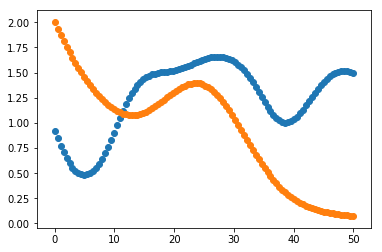

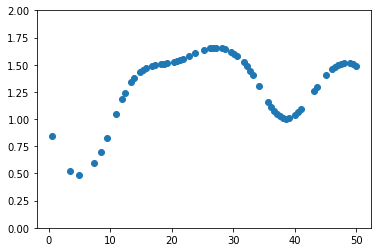

In [19]:
k = GPy.kern.RBF(input_dim = 1, variance=1, lengthscale=7)
kern = RBF(input_dim = 1, variance=1, lengthscale=7)
S, Z, N, rate, measure = build_toy_dataset1()
R = np.random.uniform(0, 1, N)
# V = (Z / rate).flatten()
C = k.K(S,S)
G = np.random.multivariate_normal(np.zeros((S.shape[0])), C + 1e-6*np.eye(len(C)))
plt.scatter(S, rate / (1.0 + np.exp(-G)))
accept = np.where(R < (1 / (1.0 + np.exp(-G))))
S_k  = np.take(S, accept, axis=0).reshape(-1,1)
Z_k  = np.take(Z, accept, axis=0).reshape(-1)
#G_k = np.log(Z_k / (rate - Z_k)).reshape(-1)
G_k = np.take(G, accept, axis=0).reshape(-1, 1)#random.multivariate_normal(np.zeros((S_k.shape[0])), k.K(S_k,S_k))
print(G_k.shape)
plt.scatter(S, Z)
plt.show()
plt.scatter(S_k, rate /(1 + np.exp(-G_k)))
plt.ylim((0, rate))
plt.show()

In [20]:
def conditional(x_new, x, y, kernel):

    B = kernel.K(x, x_new)
    A = kernel.K(x_new, x_new)
    X = kernel.K(x, x)
    N = tf.shape(X)[0]
    mu = tf.matmul(B, tf.matmul(tf.matrix_inverse(X + 1e-5*tf.eye(N)), y), transpose_a = True)
    sigma = A - tf.matmul(B, tf.matmul(tf.matrix_inverse(X + 1e-5*tf.eye(N)),B), transpose_a = True)
    return tf.squeeze(mu), tf.squeeze(sigma)

In [ ]:
x_new = tf.random_uniform((1,1))
kern = RBF(input_dim=1, lengthscale=0.1)
mu_new, sigma_new = conditional(x_new, S_k, Z_k, kern)
print(mu_new)

In [7]:
def add_event(x_new, y_new, x_M, y_M):
    x_M = tf.concat([x_M, x_new], 0)
    y_M = tf.concat([y_M, y_new], 0)
    return x_M, y_M
    
def erase_event(x_M, y_M, c):
    
    #print(tf.shape(x_M), tf.shape(y_M))
    x_M = tf.concat([tf.slice(x_M, [0,0],[c,1]), tf.slice(x_M, [c+1,0], [-1,1])], 0)
    y_M = tf.concat([tf.slice(y_M, [0,0],[c,1]), tf.slice(y_M, [c+1,0], [-1,1])], 0)
#   x_M = tf.slice(x_M, [0,0],[c-1,1])#, tf.slice(x_M, [c+1,0], [-1,1]))
#   y_M = tf.slice(y_M, [0,0],[c-1,1])#, tf.slice(y_M, [c+1,0], [-1,1]))
    return x_M, y_M

def insert_event(x_K, y_K, x_M, y_M):

    #print("Event inserted")
    M = tf.shape(x_M)[0]
    x_new = tf.random_uniform((1,1), minval=0.0, maxval=measure)
    mu_new, sigma_new = conditional(x_new, tf.concat([x_K,x_M], 0), tf.concat([y_K, y_M], 0), kern)
    y_new = tf.random_normal((1,1), mean=mu_new, stddev=tf.sqrt(sigma_new))
    ratio = tf.log(float(rate*measure))
    ratio -= tf.log(tf.cast(M+1, tf.float32))
    ratio -= tf.log(1+tf.exp(y_new))
    a = tf.random_uniform((1,))
    #print(tf.squeeze(tf.less(tf.log(a), ratio)))
    x_M, y_M = tf.cond(tf.squeeze(tf.less(tf.log(a), ratio)), lambda: add_event(x_new, y_new, x_M, y_M), lambda: (x_M, y_M))
    return x_M, y_M

def delete_util(x_M, y_M):
  
    M = tf.shape(x_M)[0]
    c = tf.random_uniform((1,), minval=0, maxval=M, dtype = tf.int32)
    c = tf.squeeze(c)
    ratio = tf.log(tf.cast(M, tf.float32))
    ratio += tf.log(1 + tf.exp(tf.slice(y_M, [c,0], [1,1])))
    ratio -= tf.log(float(rate*measure))
    a = tf.random_uniform((1,))
    x_M, y_M = tf.cond(tf.squeeze(tf.less(tf.log(a), ratio)), lambda: erase_event(x_M, y_M, c), lambda: (x_M, y_M))
    return x_M, y_M

def delete_event(x_K, y_K, x_M, y_M):
    M = tf.shape(x_M)[0]
    x_M, y_M = tf.cond(tf.equal(M, tf.constant(0)), lambda: (x_M, y_M), lambda: delete_util(x_M, y_M))
    return x_M, y_M


In [8]:
#F = tf.Variable(np.zeros((N,1)), name="FunctionVal", dtype=tf.float32)

def optimizeLogPost(G, kern):
    
#     S = tf.concat([x_K, x_M], 0)
#     G = tf.concat([y_K, y_M], 0)
#     D = tf.shape(S)[1]       # Dimension of the space
#     K = tf.shape(x_K)[0]
#     M = tf.shape(x_M)[0]
#     N = K + M
#     C = kernel.K(S,S)
    S = tf.placeholder(dtype=tf.float32, name="S")
    C = kern.K(S,S)
    #C = tf.placeholder(dtype=tf.float32, name="C")
    K = tf.placeholder(dtype=tf.int32, name="K")
    M = tf.placeholder(dtype=tf.int32, name="M")
    #F = tf.Variable(np.zeros((1,1)), dtype=tf.float32, validate_shape=False)
    N = K + M
    
    
    
    ## Learn function values via gradient optimization

    #F = tf.Variable(lambda: tf.zeros((N,1)), name="FunctionVal", dtype=tf.float32)
    #tf.Variable(F, lambda: G, validate_shape=False)
    F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)
    #init_OP = tf.global_variables_initializer()

    #print(F)
    #print(F.shape)
    prior_loss = 0.5 * tf.matmul(tf.transpose(F), tf.matmul(tf.matrix_inverse(C + 1e-6*tf.eye(N)), F))
    #print(prior_loss)
    prior_loss = tf.squeeze(prior_loss)
    likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K,1]) + tf.exp(-tf.slice(F, [0,0], [K,1]))))
    likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M,1]) + tf.exp(tf.slice(F, [K,0], [M,1]))))
    #print(likelihood_loss)
    loss = prior_loss + likelihood_loss
    
    
    #print(loss)
    train_op = tf.train.AdadeltaOptimizer(0.01, 0.95, 1e-7).minimize(loss)
    init_OP = tf.global_variables_initializer()
    return init_OP, train_op, loss, F, S, C, K, M

In [9]:

def sample_cond(x_K, y_K, x_M, y_M, i):
    return tf.less(i, tf.shape(x_M)[0])

### Change location at a particular index
def sample_step(x_K, y_K, x_M, y_M, i):
    x_new = tf.random_normal((1,1), mean=x_M[i], stddev=tf.sqrt(1.0 * measure/100.0))
    mu_new, sigma_new = conditional(x_new, tf.concat([x_K,x_M], 0), tf.concat([y_K, y_M], 0), kern)
    y_new = tf.random_normal((1,1), mean=mu_new, stddev=tf.sqrt(sigma_new))
    ratio = tf.log(1 + tf.exp(y_M[i]))
    ratio -= tf.log(1 + tf.exp(y_new))
    a = tf.random_uniform((1,))
    accept = tf.squeeze(tf.less(tf.log(a), ratio))
    x_M = tf.cond(accept, lambda: tf.concat([tf.slice(x_M, [0,0],[i,1]), tf.concat([x_new, tf.slice(x_M, [i+1,0], [-1,1])], 0)], 0), lambda: x_M)
    y_M = tf.cond(accept, lambda: tf.concat([tf.slice(y_M, [0,0],[i,1]), tf.concat([y_new, tf.slice(y_M, [i+1,0], [-1,1])], 0)], 0), lambda: y_M)
    i = tf.add(i, 1)
    return x_K, y_K, x_M, y_M, i
    
def thinned_cond(x_K, y_K, x_M, y_M, i):
    return tf.less(i, tf.constant(10))

def thinned_step(x_K, y_K, x_M, y_M, i):
    
    bern = Bernoulli(probs = bern_p)
    x_M, y_M = tf.cond(tf.equal(bern.sample(), 1), lambda: insert_event(x_K, y_K, x_M, y_M), lambda: delete_event(x_K, y_K, x_M, y_M))
    i = tf.add(i, 1)
    return x_K, y_K, x_M, y_M, i

def loop_cond(n_iter,it, x_K, y_K, x_M, y_M):
    return tf.less(it, n_iter)


In [21]:
## Loop step
def loop_step(n_iter, ind, x_K, y_K, x_M, y_M):
    
    #print(it)
    # Sample number of thinned events
    i = tf.Variable(0)
    x_K, y_K, x_M, y_M, i = tf.while_loop(thinned_cond, thinned_step, [x_K, y_K, x_M, y_M, i])
    


    #print("Thinning completed")
    # Sample thinned locations
    it = tf.Variable(0)
    x_K, y_K, x_M, y_M, it = tf.while_loop(sample_cond, sample_step, [x_K, y_K, x_M, y_M, it])
    
    #print("Locations found")

    with tf.Session() as sess:
         sess.run(tf.global_variables_initializer())
         x_K, y_K, x_M, y_M = sess.run([x_K, y_K, x_M, y_M])
    

    #return x_K, y_K, x_M, y_M
    S_i = np.concatenate([x_K, x_M], axis=0)
    
    G_i = np.concatenate([y_K, y_M], axis=0).reshape(-1)
    #init_OP, train_op, loss, F, S, C, K, M = optimizeLogPost(G_i, kern)
    
    K_i = len(x_K)
#     #M_i = len(x_M)
#     #print(G_i)
#     with tf.Session() as sess:

#         sess.run(init_OP)
#         for i in range(500):
#             sess.run(train_op, feed_dict={S:S_i, K:K_i, M:M_i})
    
#         val, loss = sess.run([F, loss], feed_dict={S:S_i, K:K_i, M:M_i})
    
#     plt.scatter(S_i, rate / (1.0 + np.exp(-G_i)))
#     plt.ylim((0, rate))
#     plt.show()
    val = slice_sampling(G_i, S_i, K_i, n_iter=10000)
    return x_K, val[:K_i], x_M, val[K_i:]
    
    
bern_p = 0.5
n_iter = 30
#x_K, y_K = tf.constant(S_k, dtype=tf.float32), tf.constant(G_k, dtype=tf.float32)
x_K, y_K = S_k.astype(np.float32), G_k.astype(np.float32)

#print(y_K)
x_M, y_M = tf.Variable(tf.zeros((0,1)), validate_shape=False), tf.Variable(tf.zeros((0,1)), validate_shape=False)
ind = tf.Variable(0)
for i in range(n_iter):
    print(i)
    res = loop_step(n_iter,ind, x_K, y_K, x_M, y_M)
    #print("Done")
    #print(res[-1])
    y_K = res[1]
    x_M = tf.Variable(res[-2], validate_shape=False)
    y_M = tf.Variable(res[-1], validate_shape=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


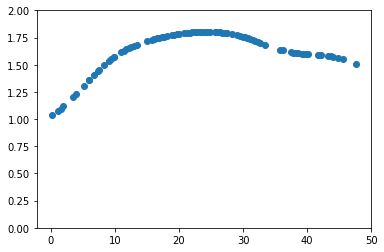

In [18]:
    
S_i = np.concatenate([x_K, res[-2]], axis=0)
    
G_i = np.concatenate([y_K, res[-1]], axis=0)
#init_OP, train_op, loss, F, S, C, K, M = optimizeLogPost(G_i, kern)

K_i = len(x_K)
#print(G_i)
plt.scatter(S_i, rate / (1.0 + np.exp(-G_i)))
plt.ylim((0, rate))
plt.show()

In [11]:
def log_posterior(g, cov_inv, K):
    
    #gX = np.matmul(np.transpose(g), cov_inv)
    #gXg = 0.5 * np.matmul(gX, g)
    log_prior = np.sum(np.log(1 + np.exp(-g[:K]))) + np.sum(np.log(1 + np.exp(g[K:])))
    return -log_prior

def slice_sampling(g, S, K, n_iter=5000):
    burn_in = 1000
    cov = k.K(S, S)
    #print("Done")
    cov_inv = np.linalg.inv(cov + 1e-5 * np.eye(len(S)))
    vec = np.zeros((n_iter, len(S)), dtype=np.float32)
    cand = np.random.multivariate_normal(np.zeros(len(S)), cov + 1e-5 * np.eye(len(S)), n_iter)
    for i in range(n_iter):
        #print(i)
        u = np.random.uniform()
        log_y = log_posterior(g, cov_inv, K) + np.log(u)
        theta = np.random.uniform(low=0.0, high=2*np.pi)
        theta_min, theta_max = theta - 2*np.pi, theta
        while(True):
            new = np.cos(theta)*g + np.sin(theta)*cand[i]
            if log_posterior(new, cov_inv, K) > log_y:
                vec[i] = new.reshape(-1)
                break
            else:
                theta_min, theta_max = (theta, theta_max) if theta<0 else (theta_min, theta)
                theta = np.random.uniform(low = theta_min, high=theta_max)
        
        g = vec[i]
                
    G = np.mean(np.array(vec)[burn_in:], axis=0).reshape(-1,1)
    return G

In [ ]:
K = len(x_K)
val = metropolis_hastings(y_K, x_K, K, n_iter=5000)

In [ ]:
plt.scatter(x_K, rate/(1.0+np.exp(-val)))
plt.show()

In [ ]:
plt.scatter(res[-2], rate/(1.0 + np.exp(-res[-1])))
plt.ylim((0, rate))
plt.show()

In [ ]:
def metropolis_hastings(g, S, K, n_iter=5000):
    vec = []
    burn_in = 1000
    with tf.Session() as sess:
        cov = sess.run(kern.K(S,S))
    
    cov_inv = np.linalg.inv(cov + 1e-5 * np.eye(len(S)))
    #print(cov_inv)
    cand = np.random.uniform(low=-3, high=3.0, size=(n_iter,len(S)))
    vec = np.zeros((n_iter, len(S)), dtype=np.float32)
    for i in range(n_iter):
        #cand = np.random.multivariate_normal(g.flatten(), cov + 1e-5*np.eye(len(S)))
        ratio = log_posterior(cand[i], cov_inv, K)
        ratio = - log_posterior(g, cov_inv, K)
        if np.log(np.random.uniform()) < ratio:
            vec[i] = cand[i]
        else:
            vec[i] = g.reshape(-1)
        g = vec[i]
    
    
    G = np.mean(np.array(vec)[burn_in:], axis=0).reshape(-1,1)
    #print(G)
#     plt.scatter(S, rate / (1.0 + np.exp(-G)))
#     plt.ylim((0, rate))
#     plt.show()
    return G